In [1]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, MaxPool2D, ReLU, Input, BatchNormalization, Concatenate, Lambda, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
#Global variable
BATCH_SIZE = 16
W,H = 256, 256
CHANNEL = 3
lr = 1e-5
epochs = 100

# Evaluation Function

In [3]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection  + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [4]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# U-NET (MODEL)

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    s5, p5 = encoder_block(p4, 512)
    s6, p6 = encoder_block(p5, 1024)

    b1 = conv_block(p6, 2048)

    d1 = decoder_block(b1, s6, 1024)
    d2 = decoder_block(d1, s5, 512)
    d3 = decoder_block(d2, s4, 256)
    d4 = decoder_block(d3, s3, 128)
    d5 = decoder_block(d4, s2, 64)
    d6 = decoder_block(d5, s1, 32)

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d6)

    model = Model(inputs, outputs, name='U-Net')
    return model

In [6]:
inputs_shape = (256,256,3)
model = build_unet(inputs_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

In [8]:
model_path = "unet_for_skull_stripping.h5"
csv_path = "unet_for_skull_stripping.csv"
path = "/kaggle/input/skull-stripping/temp"
split = 0.1

# Data Pipeline

In [9]:
#load dataset
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")), key=lambda x: int(re.search(r'\d+', x).group()))
    masks = sorted(glob(os.path.join(path, "mask/*")), key=lambda x: int(re.search(r'\d+', x).group()))

    return images, masks

In [10]:
#process image function
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img.astype(np.float32)
    return img

#process mask function
def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)
    return mask

In [11]:
#enable to apply cv
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_img(x)
        y = read_mask(y)
        return x, y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

In [12]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [13]:
images, masks = load_data(path)
print(f'image: {len(images)} - Masks: {len(masks)}')

image: 722 - Masks: 722


In [14]:
train_image = images
train_masks = masks
test_image = images[700:]
test_masks = masks[700:]
print(f'image: {len(train_image)} - Masks: {len(train_masks)}')
print(f'image: {len(test_image)} - Masks: {len(test_masks)}')

image: 722 - Masks: 722
image: 22 - Masks: 22


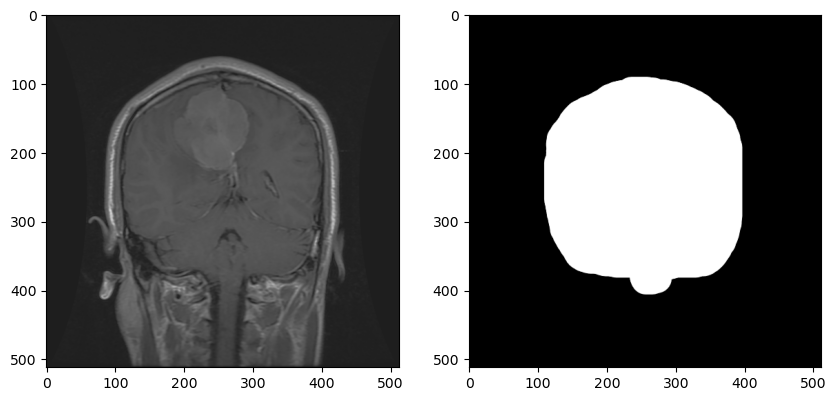

In [15]:
n = 100
img = cv2.imread(train_image[n], cv2.IMREAD_COLOR)
msk = cv2.imread(train_masks[n], cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(img)
ax[1].imshow(msk)

In [16]:
#convert dataset into tf dataset
train_dataset = tf_dataset(train_image, train_masks, batch=BATCH_SIZE)
test_dataset = tf_dataset(test_image, test_masks, batch=BATCH_SIZE)

In [17]:
#Callbacks
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
]

In [18]:
#training
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset, 
    callbacks=Callbacks
    )

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 0.6129 - dice_coef: 0.3869 - iou: 0.2408 - recall: 0.6096 - precision: 0.3985
Epoch 1: val_loss improved from inf to 0.67960, saving model to unet_for_skull_stripping.h5
46/46 [==============================] - 58s 517ms/step - loss: 0.6129 - dice_coef: 0.3869 - iou: 0.2408 - recall: 0.6096 - precision: 0.3985 - val_loss: 0.6796 - val_dice_coef: 0.3210 - val_iou: 0.1912 - val_recall: 0.0032 - val_precision: 0.0711 - lr: 1.0000e-05
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 0.4722 - dice_coef: 0.5284 - iou: 0.3599 - recall: 0.8622 - precision: 0.5524
Epoch 2: val_loss did not improve from 0.67960
46/46 [==============================] - 13s 269ms/step - loss: 0.4722 - dice_coef: 0.5284 - iou: 0.3599 - recall: 0.8622 - precision: 0.5524 - val_loss: 0.6921 - val_dice_coef: 0.3096 - val_iou: 0.1831 - val_recall: 2.7479e-04 - val_precision: 0.0586 - lr: 1.0000e-05
Epoch 3/100
46/46 [==============

# Load the model

In [19]:
with CustomObjectScope({'iou':iou, 'dice_coef':dice_coef, 'dice_loss':dice_loss}):
    model = tf.keras.models.load_model("/kaggle/working/unet_for_skull_stripping.h5")

In [20]:
path = "/kaggle/working/predicted"
create_dir(path)

# Prediction

In [21]:
for img, msk in tqdm(zip(test_image, test_masks), total=len(test_image)):
    image_name = img.split("/")[-1]

    ori_x = cv2.imread(img, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W,H))
    x = ori_x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    ori_y = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
    ori_y = cv2.resize(ori_y, (W,H))
    ori_y = np.expand_dims(ori_y, axis=-1)

    y_pred = model.predict(x)[0] > 0.5  
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred.reshape(256, 256, 1)

    print(ori_x.shape, ori_y.shape, y_pred.shape)
    save_image_path = f"/kaggle/working/predicted/{image_name}"

    sep_line = np.ones((H, 10, 3)) * 255
    cat_image = np.concatenate([ori_y, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_image)
     


  0%|          | 0/22 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 1/22 [00:01<00:34,  1.64s/it]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 23ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 3/22 [00:01<00:09,  2.07it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 5/22 [00:01<00:04,  3.60it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 25ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 7/22 [00:02<00:02,  5.13it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 46ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 39ms/step


 41%|████      | 9/22 [00:02<00:02,  6.04it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 10/22 [00:02<00:01,  6.45it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 35ms/step


 50%|█████     | 11/22 [00:02<00:01,  6.93it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 12/22 [00:02<00:01,  7.29it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 13/22 [00:02<00:01,  7.75it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 14/22 [00:02<00:00,  8.12it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 15/22 [00:03<00:00,  8.42it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 16/22 [00:03<00:00,  8.55it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 17/22 [00:03<00:00,  8.61it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 18/22 [00:03<00:00,  8.82it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 19/22 [00:03<00:00,  9.06it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 20/22 [00:03<00:00,  8.23it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 23ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 23ms/step


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)


Text(0.5, 0, 'truth ------------------------------------------------- predicted')

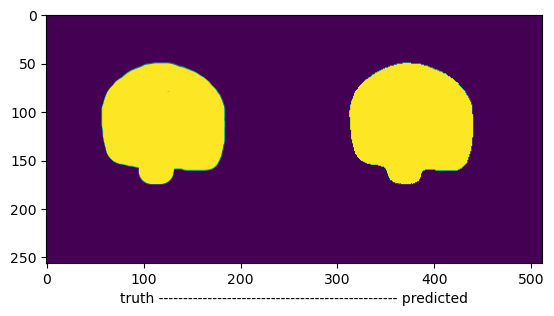

In [22]:
i = "/kaggle/working/predicted/709.png"
i = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
plt.imshow(i)
plt.xlabel("truth ------------------------------------------------- predicted")

In [23]:
t_path = "/kaggle/working/"
image_folder = sorted(glob(os.path.join(t_path, "predicted/*")))

# Visualize Prediction

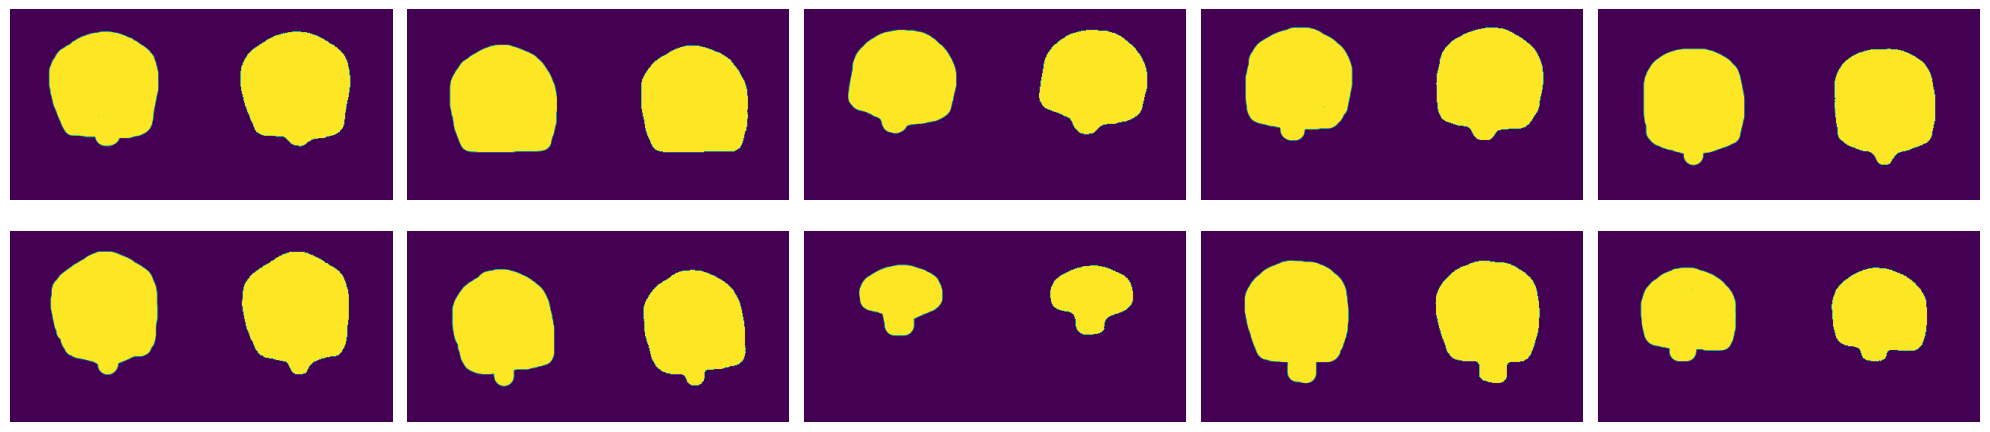

In [24]:
rows = 2
columns = 5

# Create a figure and axis objects
fig, axes = plt.subplots(rows, columns, figsize=(20, 5))

# Flatten the axes array to iterate through it easily
axes = axes.flatten()

# Loop through the images and display them
for i, ax in enumerate(axes):
    # Check if there are more images than needed for the grid
    if i < len(image_folder):
        # Read the image file
        image = mpimg.imread(image_folder[i])
        # Display the image
        ax.imshow(image)
        ax.axis("off")
    else:
        # If there are no more images, hide the remaining axes
        ax.axis("off")

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()
